In [2]:
import random
import torch
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import cv2
import shutil


from sam2.build_sam import build_sam2_video_predictor
from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm
from transformers import SiglipImageProcessor, SiglipVisionModel
from PIL import Image
from collections import defaultdict
from sklearn.cluster import KMeans

In [3]:
MODEL_PATH = Path("../../runs/detect/train4/weights/best.pt")
VAL_IMAGES_DIR = Path("../../data/tracking/YOLO/images/val")
VIDEO_OUT_DIR = Path("../../videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO(str(MODEL_PATH))
model.to(device)
print("Loaded model from:", MODEL_PATH)

names = model.names  
print("Classes:", names)

Using device: cuda
Loaded model from: runs/detect/train4/weights/best.pt
Classes: {0: 'player', 1: 'referee', 2: 'ball', 3: 'goalkeeper'}


Inference on: SNMOT-164_000157.jpg


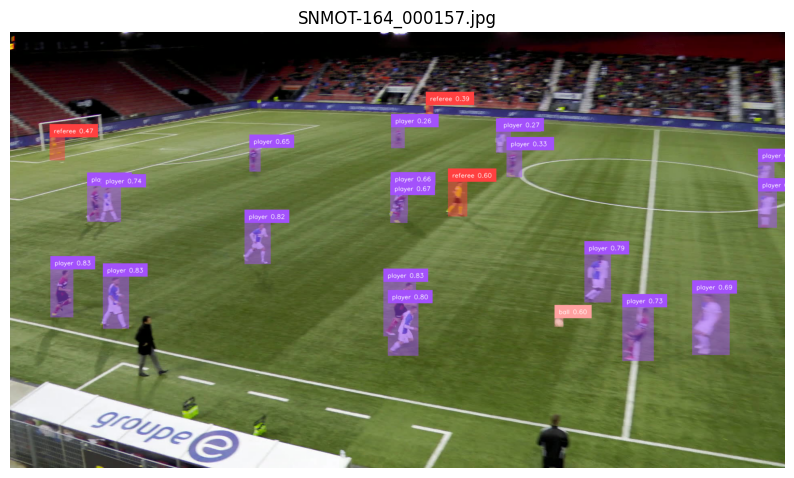

In [10]:
img_path = random.choice(list(Path(VAL_IMAGES_DIR).glob("*.jpg")))
print("Inference on:", img_path.name)

result = model(str(img_path), imgsz=640, device=device, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{names[int(cls_id)]} {conf:.2f}"
    for cls_id, conf in zip(detections.class_id, detections.confidence)
]

image_bgr = cv2.imread(str(img_path))

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_bgr = color_annotator.annotate(
    scene=image_bgr.copy(),
    detections=detections
)
annotated_bgr = label_annotator.annotate(
    scene=annotated_bgr,
    detections=detections,
    labels=labels
)

annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title(img_path.name)
plt.show()

## Tracking

```
uv pip install -q git+https://github.com/facebookresearch/segment-anything-2.git

wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt


```

In [ ]:
VAL_IMAGES_DIR = Path("data/tracking/YOLO/images/val")
all_imgs = list(VAL_IMAGES_DIR.glob("SNMOT-*_*.jpg"))

match_ids = sorted({p.stem.split("_")[0] for p in all_imgs})
print(f"Found {len(match_ids)} matches: {match_ids}")

selected_match = random.choice(match_ids)
print(f"Selected Match: {selected_match}")

match_frames = [p for p in all_imgs if p.stem.startswith(selected_match + "_")]
match_frames = sorted(match_frames, key=lambda p: int(p.stem.split("_")[1]))

max_frames = 200  # Podes limitar frames para que no te coma la memoria, los videos son de 24fps

if max_frames and len(match_frames) > max_frames:
    match_frames = match_frames[:max_frames]

print(f"Frames to process: {len(match_frames)}")


FRAMES_DIR = Path("temp_frames")

if FRAMES_DIR.exists():
    shutil.rmtree(FRAMES_DIR)
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Copying frames to {FRAMES_DIR}...")

for i, src_path in enumerate(tqdm(match_frames)):
    dst_path = FRAMES_DIR / f"{i:05d}.jpg"
    shutil.copy(src_path, dst_path)

print("Data preparation complete.")

Found 12 matches: ['SNMOT-159', 'SNMOT-160', 'SNMOT-161', 'SNMOT-162', 'SNMOT-163', 'SNMOT-164', 'SNMOT-165', 'SNMOT-166', 'SNMOT-167', 'SNMOT-168', 'SNMOT-169', 'SNMOT-170']
Selected Match: SNMOT-170
Frames to process: 200
Copying frames to temp_frames...


 22%|██▏       | 43/200 [00:00<00:00, 422.40it/s]

100%|██████████| 200/200 [00:00<00:00, 462.96it/s]

Data preparation complete.


In [ ]:
import numpy as np
import torch
import supervision as sv
from sam2.build_sam import build_sam2_camera_predictor

class SAM2Tracker:
    def __init__(self, predictor):
        self.predictor = predictor
        self._prompted = False

    def prompt_first_frame(self, frame: np.ndarray, detections: sv.Detections):
        if len(detections) == 0:
            raise ValueError("detections must contain at least one box")
        
        # Assign tracker_ids if missing
        if detections.tracker_id is None:
            detections.tracker_id = list(range(1, len(detections) + 1))

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float16):
            
            self.predictor.load_first_frame(frame)
            
            for xyxy, obj_id in zip(detections.xyxy, detections.tracker_id):
                bbox = np.asarray([xyxy], dtype=np.float32)
                # Add box prompt for the object
                self.predictor.add_new_prompt(
                    frame_idx=0,
                    obj_id=int(obj_id),
                    bbox=bbox,
                )
        self._prompted = True

    def propagate(self, frame: np.ndarray) -> sv.Detections:
        if not self._prompted:
            raise RuntimeError("Call prompt_first_frame before propagate")

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.float16):
            # Track returns: (obj_ids, mask_logits)
            tracker_ids, mask_logits = self.predictor.track(frame)

        if len(tracker_ids) == 0:
            return sv.Detections.empty()

        tracker_ids = np.asarray(tracker_ids, dtype=np.int32)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks, axis=1).astype(bool) # (N, 1, H, W) -> (N, H, W)

        # Handle single object case where dim might be lost
        if masks.ndim == 2:
            masks = masks[None, ...]

        # Filter messy segments
        clean_masks = []
        for mask in masks:
            # This helper removes small disconnected regions
            clean_masks.append(sv.filter_segments_by_distance(mask, relative_distance=0.05, mode="edge"))
        
        masks = np.array(clean_masks)
        xyxy = sv.mask_to_xyxy(masks=masks) # Update boxes based on new mask shape
        
        return sv.Detections(
            xyxy=xyxy, 
            mask=masks, 
            tracker_id=tracker_ids
        )

In [ ]:
SAM2_CHECKPOINT = "segment-anything-2-real-time/checkpoints/sam2.1_hiera_large.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "runs/detect/train12/weights/best.pt" 

print("Loading models...")
yolo_model = YOLO(MODEL_PATH)
predictor = build_sam2_camera_predictor(SAM2_CONFIG, SAM2_CHECKPOINT, device=DEVICE)
tracker = SAM2Tracker(predictor)

first_frame_path = match_frames[0]
frame_0 = cv2.imread(str(first_frame_path))

results = yolo_model(frame_0, verbose=False)[0]

valid_indices = [i for i, cls in enumerate(results.boxes.cls) if int(cls) in [0, 1, 2]]
print(valid_indices)
initial_detections = sv.Detections.from_ultralytics(results)
initial_detections = initial_detections[valid_indices]



print(f"Initializing tracker with {len(initial_detections)} objects...")
tracker.prompt_first_frame(frame_0, initial_detections)

# Create a map to remember class IDs (SAM2 only tracks Object IDs)
id_to_class_map = {
    tid: cid 
    for tid, cid in zip(initial_detections.tracker_id, initial_detections.class_id)
}



Loading models...
[0, 1, 2, 3, 4, 5, 6, 7, 8]
Detections(xyxy=array([[      757.1,      647.59,      808.64,      777.18],
       [     217.68,      464.61,      254.99,      563.67],
       [     1537.3,      552.98,      1582.6,      668.19],
       [     589.33,      434.03,      638.38,       527.9],
       [     292.94,      438.08,      327.51,      524.34],
       [     1134.3,       445.7,      1172.5,       536.3],
       [     494.57,      462.71,      531.76,      555.23],
       [     477.41,         386,      508.37,      460.95],
       [     1088.6,      400.96,        1121,      482.36]], dtype=float32), mask=None, confidence=array([    0.88956,     0.87368,     0.86879,      0.8572,     0.85455,      0.8411,     0.83449,      0.8298,     0.79854], dtype=float32), class_id=array([0, 0, 0, 0, 0, 0, 1, 0, 0]), tracker_id=None, data={'class_name': array(['player', 'player', 'player', 'player', 'player', 'player', 'referee', 'player', 'player'], dtype='<U7')}, metadata={})


In [ ]:
# --- Setup Video Writer ---
VIDEO_OUT_DIR = Path("videos")
VIDEO_OUT_DIR.mkdir(exist_ok=True)
OUTPUT_PATH = VIDEO_OUT_DIR / f"{selected_match}_sam2_realtime.mp4"

height, width = frame_0.shape[:2]
video_info = sv.VideoInfo(width=width, height=height, fps=25)
mask_annotator = sv.MaskAnnotator(opacity=0.6)
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator()

print(f"Processing {len(match_frames)} frames...")

with sv.VideoSink(str(OUTPUT_PATH), video_info=video_info) as sink:
    
    for i, img_path in enumerate(tqdm(match_frames)):
        frame = cv2.imread(str(img_path))

        if i == 0:
            annotated = mask_annotator.annotate(frame.copy(), initial_detections)
            annotated = box_annotator.annotate(annotated, initial_detections)
            sink.write_frame(annotated)
            continue
            
        detections = tracker.propagate(frame)
        
        # Recover Class IDs from our map
        if len(detections) > 0:
            recovered_classes = [id_to_class_map.get(tid, 0) for tid in detections.tracker_id]
            detections.class_id = np.array(recovered_classes)

            # Annotate
            annotated = mask_annotator.annotate(frame.copy(), detections)
            annotated = box_annotator.annotate(annotated, detections)
            
            labels = [
                f"#{tid} {yolo_model.names[cid]}"
                for tid, cid in zip(detections.tracker_id, detections.class_id)
            ]
            annotated = label_annotator.annotate(annotated, detections, labels=labels)
        else:
            annotated = frame

        sink.write_frame(annotated)

print(f"Video saved: {OUTPUT_PATH}")

Processing 200 frames...


100%|██████████| 200/200 [02:13<00:00,  1.50it/s]

Video saved: videos/SNMOT-170_sam2_realtime.mp4


## Segmentación entre equipos
